In [1]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("./modules/") # for d3plus2

sys.path.append("./../Hidalgo_Haussmann") # for HH tools
from HH_tools import *

import d3plus2 as d3plus

import numpy as np

In [82]:
path = './../growth-lab-diversity/data/sources/'
agglevel_titles = pd.read_csv(path+'agglevel_titles.csv')
area_titles = pd.read_csv(path+'area_titles.csv')
industry_titles = pd.read_csv(path+'industry_titles.csv')
industry_titles =  pd.DataFrame([['POPESTIMATE2010','Population']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)
industry_titles =  pd.DataFrame([['Cropland','Cropland'],
                                ['Desert','Desert'],
                                ['Grassland','Grassland'],
                                ['Other','Other'],
                                ['Woodland','Woodland'],
                                ['Urban','Urban'],
                                ['Water','Water']], columns = industry_titles.columns).append(industry_titles).reset_index(drop = True)

In [ ]:
path = './../growth-lab-diversity/data/sources/BLS/'

uc = ['area_fips', 'industry_code', 'agglvl_code', 'year', 'annual_avg_estabs', 'annual_avg_emplvl', 'total_annual_wages']

df_list = []
for y in np.arange(2006, 2016):
    df_y = pd.read_csv(path+str(y)+'_annual_singlefile.zip', usecols = uc, low_memory=False)
    df_list += [df_y]
    
df = pd.concat(df_list)

In [83]:
# Get robustness from using 10 years

variable = 'annual_avg_estabs'
#correct possible mistakes, index should be like c-p-y
cpy_ix = df.loc[df.agglvl_code == 76].groupby(['year', 'area_fips', 'industry_code'])[[variable]].sum()
year_avg = cpy_ix.reset_index().drop('year', axis = 1).groupby(['area_fips', 'industry_code'])[[variable]].mean()
# summary_var = df_2015.drop('year', axis = 1).loc[df_2015.agglvl_code == 76].groupby(['area_fips', 'industry_code'])[[variable]].sum()
X = year_avg.unstack()[variable]


In [84]:
# Add population

county_LU = pd.read_csv('./data/US_land_use/land_use_frac.csv', index_col=0)
county_LU.index = county_LU.index.astype(str).str.zfill(5)

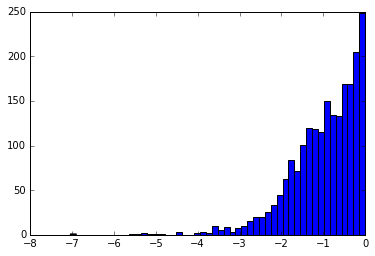

In [120]:
# plt.hist(log10(county_LU['Woodland']).dropna(), 50)
# plt.show()

In [85]:
# Add population

county_pop = pd.read_csv('./data/co-est2017-alldata.csv')
county_pop['area_fips'] = county_pop.STATE.astype(str).str.zfill(2) + county_pop.COUNTY.astype(str).str.zfill(3)

county_pop = county_pop[['area_fips', 'POPESTIMATE2010']].set_index('area_fips')

In [86]:
X = pd.concat([county_pop.loc[X.index], county_LU.loc[X.index], X], axis = 1, sort = True)#.dropna()

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if __name__ == '__main__':


In [87]:
# # Check sparsity / small areas
# # df_ = summary_var.groupby('area_fips').count().sort_values(by = variable)
# # pd.concat([df_, industry_titles.set_index('industry_code')], axis = 1, sort = False)
# # pd.concat([df_, area_titles.set_index('area_fips')], axis = 1, sort = False).dropna()

# # # Check what different choices do. 
# # # Final recommendation, take logs, don't fill gaps and use min periods >~ 20. (meth_3)

# # meth_1 = log10(summary_var.unstack()[variable]).fillna(-2).cov()
# # meth_2 = log10(summary_var.unstack()[variable]).fillna(-1).cov()
# # meth_3 = log10(summary_var.unstack()[variable]).cov(min_periods = 20).fillna(0)

# # plt.hist(meth_1.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.hist(meth_2.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.hist(meth_3.values.flatten().clip(-100, 1000), 100, linewidth = 0, alpha = .4)
# # plt.show()

# # x = meth_2.iloc[40] # meth_2.stack()
# # y = meth_3.iloc[40] # meth_3.stack()
# # plt.plot(x.values, y.values, marker = '.', alpha = .2, linewidth = 0)

# # M = log10(X)
# # M = (M.T - M.T.mean()).T

# cor_mat = log10(X).corr(min_periods = 20) # M -->log10(X)
# cov_mat = log10(X).cov(min_periods = 20)

# # We should be able to compare this to pearson correlation. 
# # However, removing area mean is necesary for this but note that row/col means are ill defined cause of logs of missing data... 
# # Here covariance can be compared to Pearson and plotted directly. It seems cov ~ pears^2

# # XTX = log10(X).T.fillna(0).dot(log10(X).fillna(0))
# # norm = np.sqrt(np.square(XTX).sum())
# # XTX = XTX.div(norm, axis = 0).div(norm) # this would convert it to Pearson if it was centered

# x = cor_mat.stack()
# y = cov_mat.stack()
# fig, ax = plt.subplots(1, figsize = (10, 10))
# ax.plot(x.values, y.values, marker = '.', alpha = .002, linewidth = 0)
# # ax.plot(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100)**2)
# ax.set_xlim(-.2, 1.1); ax.set_ylim(-.2, 1.1); #ax.set_ylim(0, 0.00001)
# ax.set_xlabel('Correlation'); ax.set_ylabel('Covariance')

In [88]:
cor_mat = log10(X).corr(min_periods = 20)
cov_mat = log10(X).cov(min_periods = 20)

In [89]:
def demean(Z):
    Z = Z.fillna(0)
    means = Z.mean()
    return (Z.T - means).T - means + means.mean()

def stand(Z):
    Z = Z.fillna(0)
    std = Z.std()
    return Z.T.div(std).T.div(std)

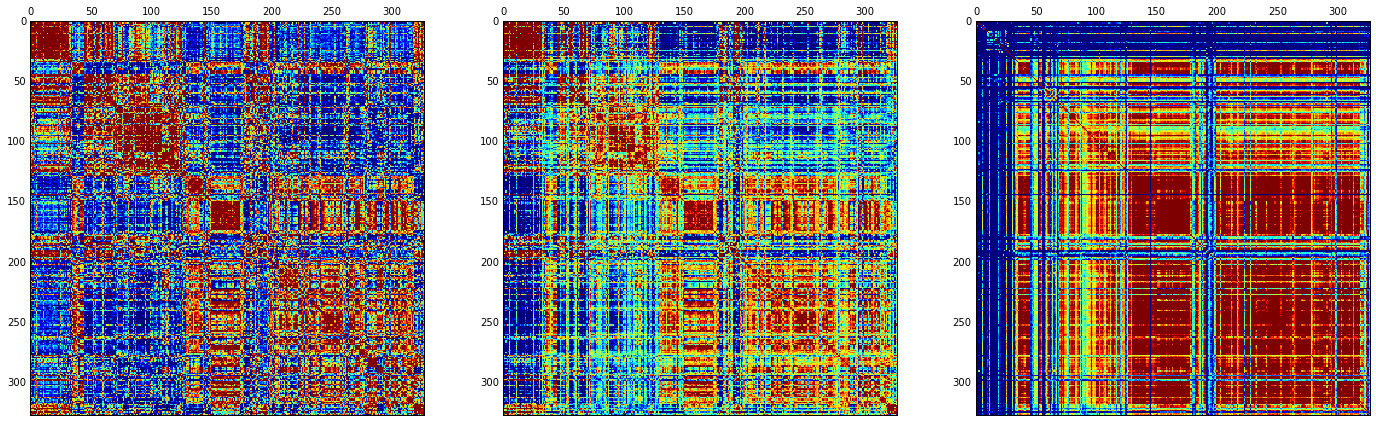

In [90]:
# mat = demean(cor_mat.fillna(0))
# mat = cor_mat
fig, axs = plt.subplots(1, 3, figsize = (24, 8))

axs[0].matshow(demean(stand(demean(cor_mat))), vmin = -10, vmax = 10)
axs[1].matshow(demean(cor_mat), vmin = -.1, vmax = .1)
axs[2].matshow(cor_mat.fillna(0), vmin = .2, vmax = .7)

# plt.hist(stand(demean(cor_mat)).std(), 30)
# plt.show()

In [91]:
# Try spectral clustering. Works when matrix is demeaned
from sklearn.cluster import SpectralClustering
X_ = demean(cor_mat).values
clustering = SpectralClustering(n_clusters=10,
        assign_labels="discretize",
        random_state=0).fit(X_)

pd.options.display.max_rows = 500
clust_result = pd.DataFrame(clustering.labels_, index = X.columns, columns = ['cluster'])
clust_result = pd.concat([clust_result, industry_titles.set_index('industry_code')], axis = 1, sort = False).dropna().sort_values(by = ['cluster', 'industry_title'])

In [92]:
edges = pd.DataFrame(demean(cor_mat).stack(), columns = ['dem_corr'])
# > demean(cor_mat).values, 90
# edges.loc[]
edges_s = edges.loc[edges.dem_corr > edges.dem_corr.quantile(.9)]
edges_s.index.names = ['industry_code_x', 'industry_code_y']
edges_s = edges_s.reset_index().merge(
    industry_titles, left_on = 'industry_code_x', right_on = 'industry_code').merge(
    industry_titles, left_on = 'industry_code_y', right_on = 'industry_code').T.drop_duplicates().T
edges_s['dem_corr'] = edges_s['dem_corr'].astype(float)

In [93]:
# #Load modules
# from numpy.random import choice 
# from numpy import where, power

In [94]:
import matplotlib.colors as mcolors

# nodes = industry_titles

nodes_size = pd.DataFrame(np.sqrt(X.sum()), columns=['sqrt_size'])
nodes = pd.concat([nodes_size, clust_result], axis = 1, sort = False)

norm = mcolors.Normalize(vmin=0, vmax=10, clip=True)
mapper = plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet)

nodes['color'] = nodes['cluster'].apply(lambda x: mcolors.rgb2hex(mapper.to_rgba(x)))

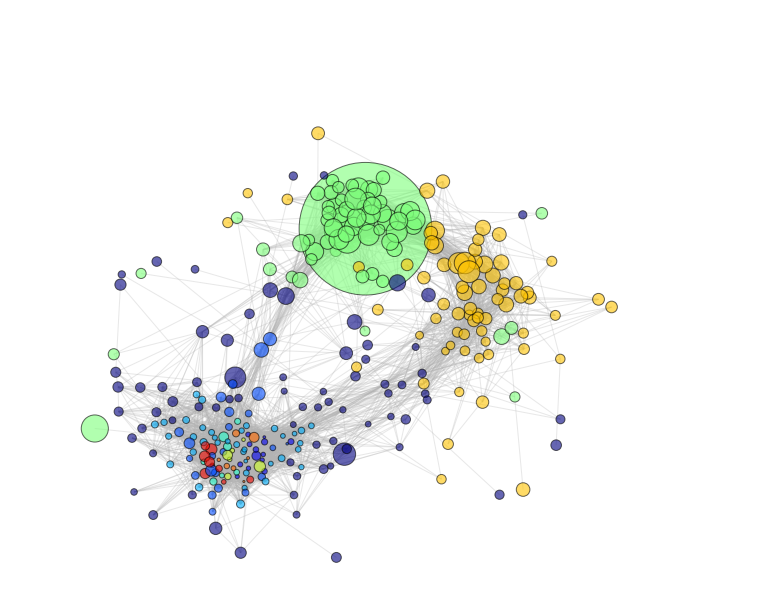

In [95]:
max_d = 200
weight_column = 'dem_corr' #'weight_'+geo

        ### Max degree = max_d. Parameter used to trim the network.
df1 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
df2 = edges_s.groupby('industry_code_x').apply(lambda x: x.nlargest(max_d, weight_column)).reset_index(drop = True)
edges_max_d = df1.merge(df2, on = ['industry_code_x', 'industry_title_x', 'industry_code_y', 'industry_title_x', weight_column]).reset_index(drop = True)

###

# Hard threshold and max degree backboning

G = nx.from_pandas_edgelist(edges_max_d, 'industry_code_x', 'industry_code_y', weight_column)


plt.figure(figsize = (10, 8))

G = max(nx.connected_component_subgraphs(G), key=len)
nodes_s = nodes.loc[G.nodes.keys()]
pos = nx.spring_layout(G, k=.4)

nx.draw(G, pos, node_size = nodes_s.sqrt_size.values, alpha=.6, node_color= list(nodes_s.color.values), edgelist = [])
nx.draw_networkx_edges(G, pos, edge_color='.7', alpha=.3)
# plt.title('max_d = '+str(max_d))
#     plt.savefig('./Figures/5_max_deg/'+col_name+'_plot1.png')
#             plt.show()

plt.show()

### Draw in d3plus

In [96]:
# nodes
pos_df = pd.DataFrame(pos, index = ['x', 'y']).T
nodes_wpos = pd.concat([nodes_s, pos_df], axis = 1, sort = False)

In [104]:
nodes_ = nodes_wpos.reset_index()[['index','x', 'y', 'industry_title', 'color']].dropna(subset = ['x']).rename({'index': 'id'}, axis = 1)
nodes_['id'] = nodes_['id'].astype(str).str.zfill(4)
nodes_[['x', 'y']] = 1000 * nodes_[['x', 'y']]


In [98]:
nodes_.head()

,id,x,y,industry_title,color
0,1142,-434.215317,-696.708067,NAICS 1142 Hunting and trapping,#0000f1
1,5173,706.821464,-225.289104,NAICS 5173 Wired and wireless telecommunicatio...,#ffc400
2,1141,-492.859941,-452.743570,NAICS 1141 Fishing,#004cff
3,3335,-785.359772,-287.558068,NAICS 3335 Metalworking machinery manufacturing,#000080
4,5175,-669.447205,573.688381,NAICS02 5175 Cable and other program distribution,#000080


In [99]:
nodes_.loc[nodes_.id == 'Desert']

,id,x,y,industry_title,color
196,Desert,-308.616052,-519.130957,Desert,#0000f1


In [100]:
import sys
sys.path.append("./../Hidalgo_Haussmann") # for HH tools
import pandas as pd
from HH_tools import robust_proximity, year_to_tp, RCA

In [105]:
nodes_['presence'] = True

edges_max_d['edge_tuple'] = list(zip(edges_max_d.industry_code_x, edges_max_d.industry_code_y))
edges_max_d['edge_tuple_rev'] = list(zip(edges_max_d.industry_code_y, edges_max_d.industry_code_x))
edges_max_d_triangles = edges_max_d.loc[edges_max_d.edge_tuple.isin(G.edges()) | edges_max_d.edge_tuple_rev.isin(G.edges())]

links = edges_max_d_triangles.reset_index().rename({weight_column: 'strength'},axis = 1)
links['target'] = links['industry_code_y'].astype(str).str.zfill(4)
links['source'] = links['industry_code_x'].astype(str).str.zfill(4)

# links = nc_backbone.reset_index().rename({'score': 'strength'},axis = 1)
# links['target'] = links['trg'].astype(str).str.zfill(4)
# links['source'] = links['src'].astype(str).str.zfill(4)

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'
# network

In [106]:
edges_max_d_triangles.to_csv('edges_max_d_triangles.csv', index = False)

In [107]:
ps = d3plus.ProductSpace(
id="name",
name="industry_title",
color="color",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

### Color by Population Density

In [26]:
processed_data_path = './../../../../../media/miglesia/Elements/corr_st_data/'

main_tables = pd.concat([pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2011_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2012_2013.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2011.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2012.csv'),
           pd.read_csv('./../../../../../media/miglesia/Elements/corr_st_data/CHI_COM_W4_O4_E2_I4_main_table_2014_2013.csv')])

main_table = main_tables.groupby('CHI ID COM').mean()/2.

# change node names into node index
# main_table.rename(columns = dict(zip(nodes.node_name, nodes.index)), inplace = True)

population = pd.read_csv('./data/pop_dist_comuna.csv').rename(columns = {'comuna_id': 'CHI ID COM'})

/home/miglesia/anaconda2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [27]:
from numpy import log10
population['log_dens'] = log10(population['densidad'])
b = 8; population['log_dens_cat'] = pd.cut(population['log_dens'], b)

bins = pd.cut(population['log_dens'], b, retbins=True)[1]
bins_mean = (bins[1:] + bins[:-1])/2.

merged = pd.concat([population.set_index('CHI ID COM')[['log_dens_cat']].sort_index(), main_table], axis = 1)
popdens_RCA = RCA(merged.groupby('log_dens_cat').sum())

popdens_RCA_normed = popdens_RCA/popdens_RCA.sum()

In [28]:
pop_dens_index = pd.DataFrame((popdens_RCA_normed.T*bins_mean).T.sum(), columns = ['pop_dens_index'])
pop_dens_index = pop_dens_index.reset_index().rename(columns={'index':'node_name'})
nodes_ = nodes_.merge(pop_dens_index, on = 'node_name', how = 'left')
nodes_['pop_dens_color_code'] = pd.cut(nodes_['pop_dens_index'], bins = 7, labels=False)

from numpy import nan
rainbow_colors = {0:'#9400D3', #Violet
1:'#4B0082', #Indigo
2:'#0000FF', #Blue
3:'#00FF00', #Green
nan:'#D3D3D3',  #'#D3D3D3', #Gray
4:'#FFFF00', #Yellow
5:'#FF7F00', #Orange
6:'#FF0000'} #Red

nodes_['color_2'] = pd.DataFrame(nodes_['pop_dens_color_code'].map(rainbow_colors))

network = '{"nodes": '+nodes_.to_json(orient= 'records')+', "edges": '+links[['index', 'source', 'target']].to_json(orient= 'records')+'}\n'

In [29]:
ps = d3plus.ProductSpace(
id="name",
name="node_name",
color="color_2",
graph_data=network,
presence="presence",
edge_property="edges",
network_id="id")
ps.draw(nodes_)

<IPython.core.display.Javascript object>

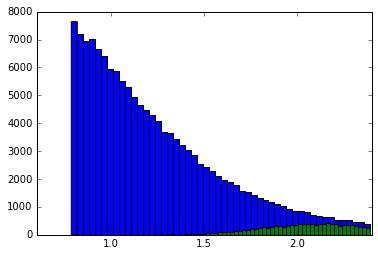

In [30]:
plt.hist(edges.weight_CHI_COM.values, 50)
plt.hist(edges_max_d.weight_CHI_COM.values, 50)
plt.show()